# INGRESO DE DATOS

In [137]:
recubrimiento=4         #cm
fc = 280                  #kg/cm2    #Resistencia a la compresion del concreto 
fy = 4200                 #kg/cm2    #Resistencia a la fluencia del acero
Es = 2.00*10**6           #kg/cm2    #Modulo de elasticidad del acero 
base = 40                 #cm  
altura = 60               #cm 
numero_aceros_x = 4
numero_aceros_y = 6
diametros = "5/8"         #pulg  "1/4"   "3/8"    "1/2"   "5/8"  "3/4"    "1"  
carga_momento = [14.5,5,2,8,14.1,5,8]             #ton.m  
carga_compresion = [48,67.2,22,42,22,120,100]     #ton
etiqueta = "C12 Nivel 1"

# PROCESO

## LIBRERIAS

In [138]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## CALCULOS INTERMEDIOS

<img src="Imagenes\distancias_de_aceros.jpg">

In [139]:
#calculos para obtener datos adicionales
dprima=recubrimiento                        # d´
peralte_efectivo=altura-recubrimiento       # d
altura_efectiva=altura-2*recubrimiento
altura_espaciamiento=altura_efectiva/(numero_aceros_y-1)
Ag=base*altura
numero_aceros=2*(numero_aceros_x)+2*(numero_aceros_y)-4

εc = 0.003   #Deformacion maxima del concreto
εy = fy/Es   #Deformacion maxima del acero

#Calculos de las distancias de cada varilla
distancias=[]
for i in range(numero_aceros_y):
    distancias=distancias+[altura_espaciamiento*(i)+recubrimiento]
distancias2=list(distancias)  
#Ec=15000.00*sqrt(fc)

#Calculo de areas de acero
if diametros=="1/4":
    As1=0.32
if diametros=="3/8":
    As1=0.71
if diametros=="1/2":
    As1=1.27
if diametros=="5/8":
    As1=1.98
if diametros=="3/4":
    As1=2.84
if diametros=="1":
    As1=5.10  #5.07

Areas_nn=[0 for i in range(numero_aceros_y)]
for i in range(numero_aceros_y):
    if i == 0 or i == (numero_aceros_y-1):
        Areas_nn[i]=As1*(numero_aceros_x)
    else:
        Areas_nn[i]=As1*2.00
#Beta 1 
if fc < 280:
    beta1=0.85
else:
    beta1=max(0.85-0.05*(fc-280)/7,0.65)

cuantia=sum(Areas_nn)/Ag

## COEFICIENTES DE REDUCCION

### Factor de resistencia segun ACI

<img src="Imagenes\phi_aci.jpg">

In [140]:
def phi_ACI(εs,εy):
    phi_factor = 0.65 + 0.25*(εs - εy)/(0.005-εy)
    if phi_factor >= 0.90:
        phi = 0.90        #Controlado por la Tension
    elif phi_factor <= 0.65:
        phi = 0.65,       #Controlado por la Compresion
    else:
        phi = phi_factor  #Transicion
    return phi

### Factor de resistencia segun E060

<img src="Imagenes\phi_E060.jpg">

In [141]:
def phi_E060(Suma_Tensiones_normales):
    phi=0.65
    if Suma_Tensiones_normales>0.1*(base*altura)*fc:
        phi=0.65
    elif Suma_Tensiones_normales>0:
        #phi=0.9-4.96*10**(-6)*Suma_Tensiones_normales
        phi=0.9-2/(fc*Ag)*Suma_Tensiones_normales
    else:
        phi=0.9
    return phi

## FUNCION
Genera los puntos del diagrama de interaccion

### Calculo de Dagrama de interaccion ACI

<img src="Imagenes\Datos_geometricos.png">

Los diagramas de interacción permiten representar la acción conjunta de cargas axiales “P” y momentos flectores “M” que conducen a diversos modos de falla de una columna; delimitándonos en este estudio a la sección típica y al material
concreto armado.

In [142]:
def Diagrama_interaccion_ACI(c,εc,fc,base,εy,Es,Areas_nn,fy,distancias2,altura):
    εsi = [0 for i in range(numero_aceros_y)] 
    fsi = [0 for i in range(numero_aceros_y)] 
    Fi = [0 for i in range(numero_aceros_y)] 
    Fi_di = [0 for i in range(numero_aceros_y)] 
    Cc = [0 for i in range(numero_aceros_y)] 
    BP = [0 for i in range(numero_aceros_y)] 
    MP = [0 for i in range(numero_aceros_y)] 

    #Deformacion de la fibra de acero:
    for i in range(numero_aceros_y):
        if c>distancias2[i]:
            εsi[i] = εc*(c-distancias2[i])/c
        else:
            εsi[i] = εc*(distancias2[i]-c)/c 

    #Esfuerzo del acero:
    #f = εs. Es
    for i in range(numero_aceros_y):    
        if εsi[i] <= εy:
            fsi[i] = Es*εsi[i]
        else:
            fsi[i] = fy

    #Fuerza del acero
    #Fi = As. fi
    for i in range(numero_aceros_y):
        if c >distancias2[i] or i ==0:        
            Cc[i]=Areas_nn[i]*fsi[i]
        else:
            Cc[i]=-1*Areas_nn[i]*fsi[i]

    #Distancias de los aceros al Centroide Plastico:
    for i in range(numero_aceros_y):
        if altura*0.5>distancias2[i]:               
            BP[i]=0.5*altura-distancias2[i]         #COMPRESION
        else:
            BP[i]=distancias2[i]-0.5*altura         #TRACCION

    #Momentos de la fuerza de los aceros con respecto al Centroide Plastico
    for i in range(numero_aceros_y):
        if distancias2[i]>0.5*altura or BP[i]*Cc[i]<0:
            MP[i]=-1*BP[i]*Cc[i]
        else:
            MP[i]=BP[i]*Cc[i]

    F_concreto=0.85*fc*(0.85*c)*base                   #Fuerza de compresion del concreto
    M_concreto=F_concreto*(altura*0.5-0.85*c*0.5)  
    Cc.append(F_concreto)
    MP.append(M_concreto)
    
    Suma_Tensiones_normales=sum(Cc)
    Suma_Momentos_normales=sum(MP)

    phi = phi_ACI(εsi[-1],εy)  
    PU=np.array(Suma_Tensiones_normales)*phi
    MU=np.array(Suma_Momentos_normales)*phi

    carga_nom=Suma_Tensiones_normales
    carga_ult=PU
    momento_nom=Suma_Momentos_normales
    momento_ult=MU

    return carga_nom, carga_ult, momento_nom, momento_ult

### Calculo de Diagrama de interaccion E060

<img src="Imagenes\Withney.jpg">

In [143]:
def Diagrama_interaccion_E060(c,εc,fc,base,εy,Es,Areas_nn,fy,distancias2,altura):
    εsi = [0 for i in range(numero_aceros_y)] 
    fsi = [0 for i in range(numero_aceros_y)] 
    Fi = [0 for i in range(numero_aceros_y)] 
    Fi_di = [0 for i in range(numero_aceros_y)] 
    Cc = [0 for i in range(numero_aceros_y)] 
    BP = [0 for i in range(numero_aceros_y)] 
    MP = [0 for i in range(numero_aceros_y)] 

    #Deformacion de la fibra de acero:
    for i in range(numero_aceros_y):
        if c>distancias2[i]:
            εsi[i] = εc*(c-distancias2[i])/c
        else:
            εsi[i] = εc*(distancias2[i]-c)/c 

    #Esfuerzo del acero:
    #f = εs. Es
    for i in range(numero_aceros_y):    
        if εsi[i] <= εy:
            fsi[i] = Es*εsi[i]
        else:
            fsi[i] = fy

    #Fuerza del acero
    #Fi = As. fi
    for i in range(numero_aceros_y):
        if c >distancias2[i] or i ==0:       
            Cc[i]=Areas_nn[i]*fsi[i]
        else:
            Cc[i]=-1*Areas_nn[i]*fsi[i]

    #Distancias de los aceros al Centroide Plastico:
    for i in range(numero_aceros_y):
        if altura*0.5>distancias2[i]:               
            BP[i]=0.5*altura-distancias2[i]         #COMPRESION
        else:
            BP[i]=distancias2[i]-0.5*altura         #TRACCION

    #Momentos de la fuerza de los aceros con respecto al Centroide Plastico
    for i in range(numero_aceros_y):
        if distancias2[i]>0.5*altura or BP[i]*Cc[i]<0:
            MP[i]=-1*BP[i]*Cc[i]
        else:
            MP[i]=BP[i]*Cc[i]

    F_concreto=0.85*fc*(0.85*c)*base                   #Fuerza de compresion del concreto
    M_concreto=F_concreto*(altura*0.5-0.85*c*0.5)  
    Cc.append(F_concreto)
    MP.append(M_concreto)
    
    Suma_Tensiones_normales=sum(Cc)
    Suma_Momentos_normales=sum(MP)

    phi=phi_E060(Suma_Tensiones_normales)

    PU=np.array(Suma_Tensiones_normales)*phi
    MU=np.array(Suma_Momentos_normales)*phi

    carga_nom=Suma_Tensiones_normales
    carga_ult=PU
    momento_nom=Suma_Momentos_normales
    momento_ult=MU

    return carga_nom, carga_ult, momento_nom, momento_ult

## GENERACION DE PUNTOS DEL DIAGRAMA

### COMPRESION PURA

In [144]:
Ast=numero_aceros*As1
Pn=(0.85*fc*(Ag-Ast)+Ast*fy)
Pnmax=0.8*Pn  #Para columnas con estribos
#Φ=0.65 factor de minoracion para seccion controladas por compresion
Pumax=0.65*Pnmax              
PCPN=[0,Pnmax]
PCPU=[0,Pumax]
# print(Pn)

### GENERANDO PUNTOS

#### ACI

In [145]:
carga_nom_ACI=[]
carga_ult_ACI=[]
momento_nom_ACI=[]
momento_ult_ACI=[]

valores_c = np.arange(altura+altura/4,recubrimiento,-0.5)
for c in valores_c:
    CN_ACI, CU_ACI, MN_ACI, MU_ACI = Diagrama_interaccion_ACI(c,εc,fc,base,εy,Es,Areas_nn,fy,distancias2,altura)
    carga_nom_ACI.append(CN_ACI)
    carga_ult_ACI.append(CU_ACI)
    momento_nom_ACI.append(MN_ACI)
    momento_ult_ACI.append(MU_ACI)

#### E060

In [146]:
carga_nom_E060=[]
carga_ult_E060=[]
momento_nom_E060=[]
momento_ult_E060=[]

valores_c = np.arange(altura+altura/4,recubrimiento,-0.5)   #FALTA AJUSTAR ESTE VALOR....SERIA RECOMENDABLE 
for c in valores_c:
    CN_E060, CU_E060, MN_E060, MU_E060 = Diagrama_interaccion_E060(c,εc,fc,base,εy,Es,Areas_nn,fy,distancias2,altura)
    carga_nom_E060.append(CN_E060)
    carga_ult_E060.append(CU_E060)
    momento_nom_E060.append(MN_E060)
    momento_ult_E060.append(MU_E060)

### TRACCION PURA

In [147]:
P_T=-Ast*fy
Mn_T=0.00
TP=[Mn_T,P_T]
TPU=[0.9*Mn_T,0.9*P_T]

### FALLA BALANCEADA

In [148]:
#Para el ploteo
carga_nom_bal=[]
momento_nom_bal=[]

Cb=(6000.00*peralte_efectivo)/(6000.00+fy)
Pn_bal, Pu_bal, Mn_bal, Mu_bal = Diagrama_interaccion_ACI(Cb,εc,fc,base,εy,Es,Areas_nn,fy,distancias2,altura)
#No importa que diagrama se utilice, la falla balanceada es la misma
carga_nom_bal.append((Pn_bal))
momento_nom_bal.append((Mn_bal))
carga_nom_bal.append((0))
momento_nom_bal.append((0))

### UNION DE PUNTOS

#### ACOMODO DE PUNTOS DE LA CURVA ACI

In [149]:
#Uniendo los puntos del diagrama y dando forma 
carga_nom_r_ACI=[i for i in (carga_nom_ACI)]
carga_ult_r_ACI= [i for i in (carga_ult_ACI)]
momento_nom_r_ACI=[i for i in (momento_nom_ACI)]
momento_ult_r_ACI=[i for i in (momento_ult_ACI)]

for i in range(len(carga_nom_ACI)):
    if carga_nom_ACI[i]>=Pnmax:
        carga_nom_r_ACI[i]=Pnmax

for i in range(len(carga_ult_ACI)):
    if carga_ult_ACI[i]>=Pumax:
        carga_ult_r_ACI[i]=Pumax  

#uniendo el punto de traccion pura  
carga_nom_r_ACI.append(P_T)     
momento_nom_r_ACI.append(0)
carga_ult_r_ACI.append(0.9*P_T)
momento_ult_r_ACI.append(0)

#### ACOMODO DE PUNTOS DE LA CURVA E060

In [150]:
#Uniendo los puntos del diagrama y dando forma 
carga_nom_r_E060=[i for i in (carga_nom_E060)]
carga_ult_r_E060= [i for i in (carga_ult_E060)]
momento_nom_r_E060=[i for i in (momento_nom_E060)]
momento_ult_r_E060=[i for i in (momento_ult_E060)]
for i in range(len(carga_nom_E060)):
    if carga_nom_E060[i]>=Pnmax:
        carga_nom_r_E060[i]=Pnmax

for i in range(len(carga_ult_E060)):
    if carga_ult_E060[i]>=Pumax:
        carga_ult_r_E060[i]=Pumax  

    

#uniendo el punto de traccion pura  
carga_nom_r_E060.append(P_T)     
momento_nom_r_E060.append(0)
carga_ult_r_E060.append(0.9*P_T)
momento_ult_r_E060.append(0)

# GRAFICOS

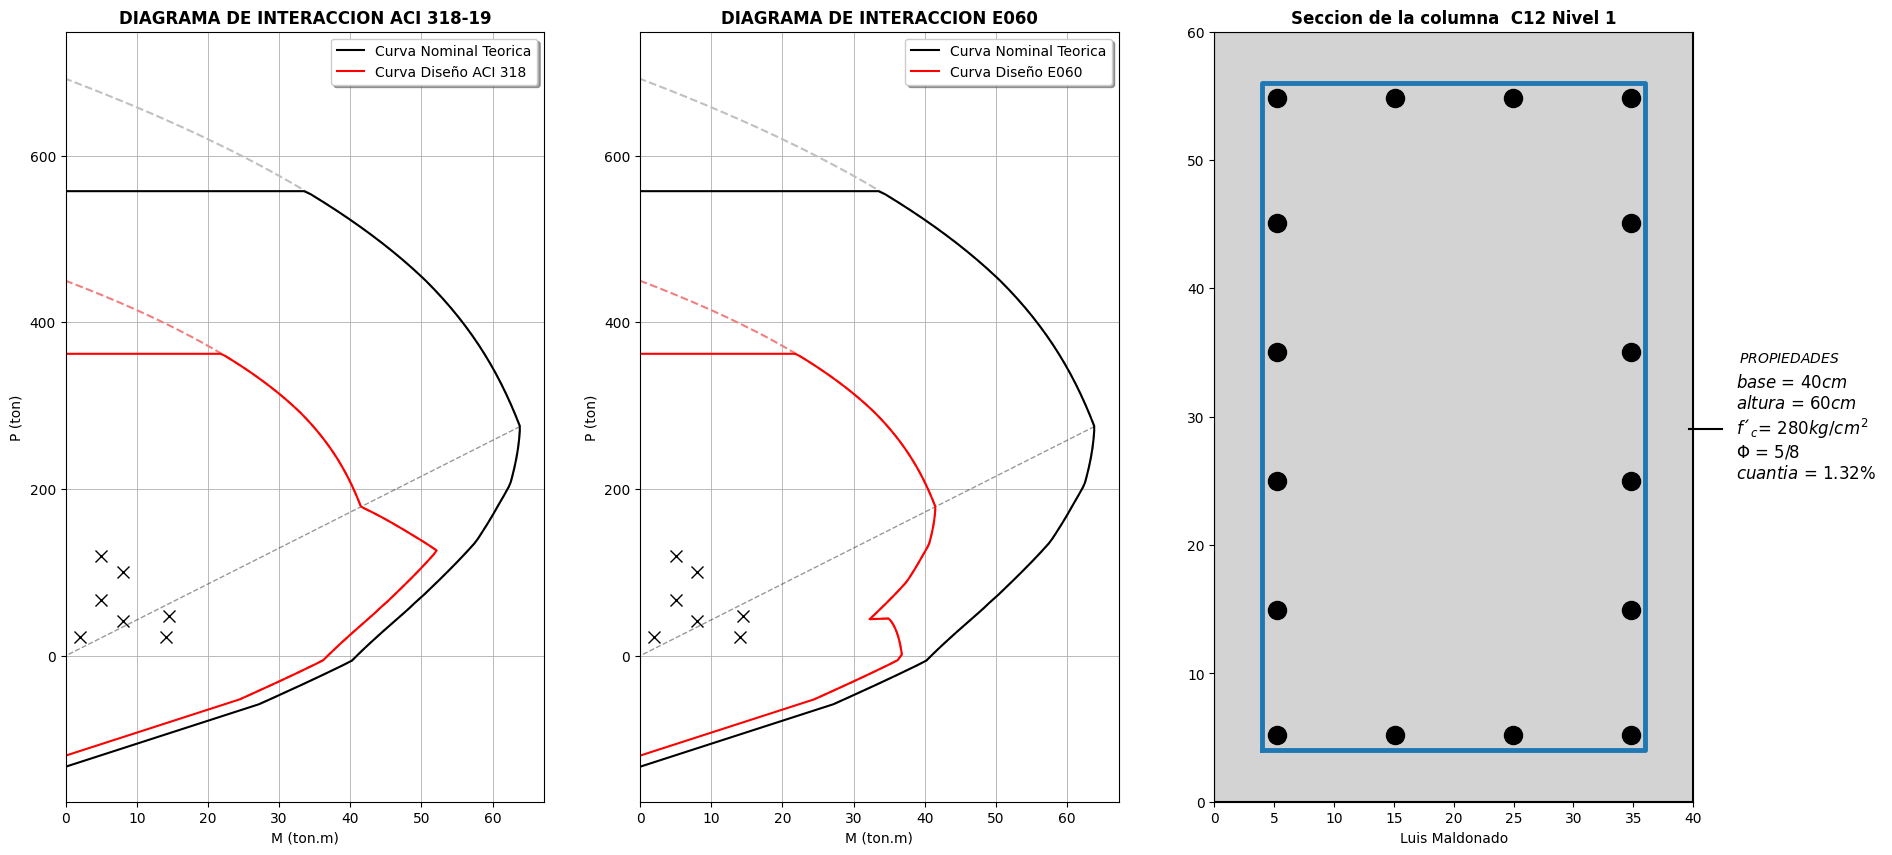

In [151]:

#ACI
fig = plt.figure(figsize=(21,10))
ax1 = plt.subplot(1,3,1)
ax1.plot(np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='--',color="black", linewidth=1,alpha=0.4)
ax1.plot(np.array(momento_nom_ACI,dtype=object)/100000,np.array(carga_nom_ACI,dtype=object)/1000,linestyle='--',color="silver")
C_N,=ax1.plot(np.array(momento_nom_r_ACI)/100000,np.array(carga_nom_r_ACI)/1000,linestyle='-',color="black")
ax1.plot(np.array(momento_ult_ACI,dtype=object)/100000,np.array(carga_ult_ACI,dtype=object)/1000,linestyle='--',color="lightcoral")
C_D,=ax1.plot(np.array(momento_ult_r_ACI,dtype=object)/100000,np.array(carga_ult_r_ACI,dtype=object)/1000,linestyle='-',color="red")

ax1.plot(carga_momento,carga_compresion,"kx",ms=9)
ax1.set_ylabel("P (ton)")
ax1.set_xlabel("M (ton.m)")
ax1.set_title("DIAGRAMA DE INTERACCION ACI 318-19",fontweight="bold")
ax1.legend((C_N,C_D),("Curva Nominal Teorica","Curva Diseño ACI 318"), loc='upper right', shadow=True)
ax1.grid(linewidth=0.6)
#ax1.set(xlim=(0), ylim=(0))
ax1.set(xlim=(0))
plt.axis("on")
ax1.set_facecolor("white")

#E060
ax2 = plt.subplot(1,3,2)
ax2.plot(np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='--',color="black", linewidth=1,alpha=0.4)
ax2.plot(np.array(momento_nom_E060)/100000,np.array(carga_nom_E060)/1000, label="Curva Nominal",linestyle='--',color="silver")
C_N,=ax2.plot(np.array(momento_nom_r_E060)/100000,np.array(carga_nom_r_E060)/1000, label="Curva Nominal",linestyle='-',color="black")
ax2.plot(np.array(momento_ult_E060)/100000,np.array(carga_ult_E060)/1000,label="Curva Diseño",linestyle='--',color="lightcoral")
C_D,=ax2.plot(np.array(momento_ult_r_E060)/100000,np.array(carga_ult_r_E060)/1000,label="Curva Diseño",linestyle='-',color="red")
ax2.plot(carga_momento,carga_compresion,"kx",ms=9)
ax2.set_ylabel("P (ton)")
ax2.set_xlabel("M (ton.m)")
ax2.set_title("DIAGRAMA DE INTERACCION E060",fontweight="bold")
ax2.legend((C_N,C_D),("Curva Nominal Teorica","Curva Diseño E060"), loc='upper right', shadow=True)
ax2.grid(linewidth=0.6)
#ax2.set(xlim=(0), ylim=(0))
ax2.set(xlim=(0))
plt.axis("on")
ax2.set_facecolor("white")

#SECCION
#variables y operaciones para definir la geometria de la seccion de la columna
b=base
h=altura
e=4       #cm  # recubrimiento
rx=1.2      #variable, hace referencias al diametro en el plot
ry=0.9
rectangulo_x=[0,b,b,0,0]
rectangulo_y=[0,0,h,h,0]
estribo_x=[e,b-e,b-e,e,e]
estribo_y=[e,e,h-e,h-e,e]
k_x=numero_aceros_x-1
k_y=numero_aceros_y-1
s_x=(b-2*e-2*rx)/k_x
s_y=(h-2*e-2*ry)/k_y
varillas_x=[]
varillas_y=[]
for i in range(numero_aceros_x):
    varillas_x.append((i)*s_x+e+rx)
for i in range(numero_aceros_y):
    varillas_y.append((i)*s_y+e+ry)
varillas_y.pop(0)
varillas_y.pop(-1)
vx=varillas_x
vy=varillas_y
#print(s_y)
vy1=[]
vy2=[]
vx1=[]
vx2=[]
for i in range(numero_aceros_x):
    vy1.append(e+1.2)
    vy2.append(h-e-1.2)
for i in range(numero_aceros_y-2):
    vx1.append(e+1.2)
    vx2.append(b-e-1.2)
#PLOTEO DE SECCION DE LA COLUMNA
#PLOT 2
ax3=plt.subplot(1,3,3)
ax3.plot(rectangulo_x,rectangulo_y,"k-")
ax3.plot(vx,vy1,"ko",ms = 13)
ax3.plot(vx,vy2,"ko",ms = 13)
ax3.plot(vx1,vy,"ko",ms = 13)
ax3.plot(vx2,vy,"ko",ms = 13)
ax3.plot(estribo_x,estribo_y,linestyle='-',linewidth=3.5)
ax3.set_title("Seccion de la columna  " + str(etiqueta),fontweight="bold")
plt.xlabel("Luis Maldonado",)
#plt.axis('off')
ax3.set_facecolor("lightgray")
ax3.set(xlim=(0,b), ylim=(0,h))
label = [ "$base$ = " +str(base)+ "$ cm$"+'\n$altura$ = '+str(altura)+ "$ cm$"+'\n$f´_{c} $= '+str(fc)+"$kg/cm^2$"+'\n$Φ$ = '+str(diametros)+'\n$cuantia$ = '+str(round(cuantia*100,2))+"%"]
ax3.legend(label,loc='center left',bbox_to_anchor=(0.96, 0.5),frameon=False,title= "   $PROPIEDADES$",fontsize=12)
plt.show()

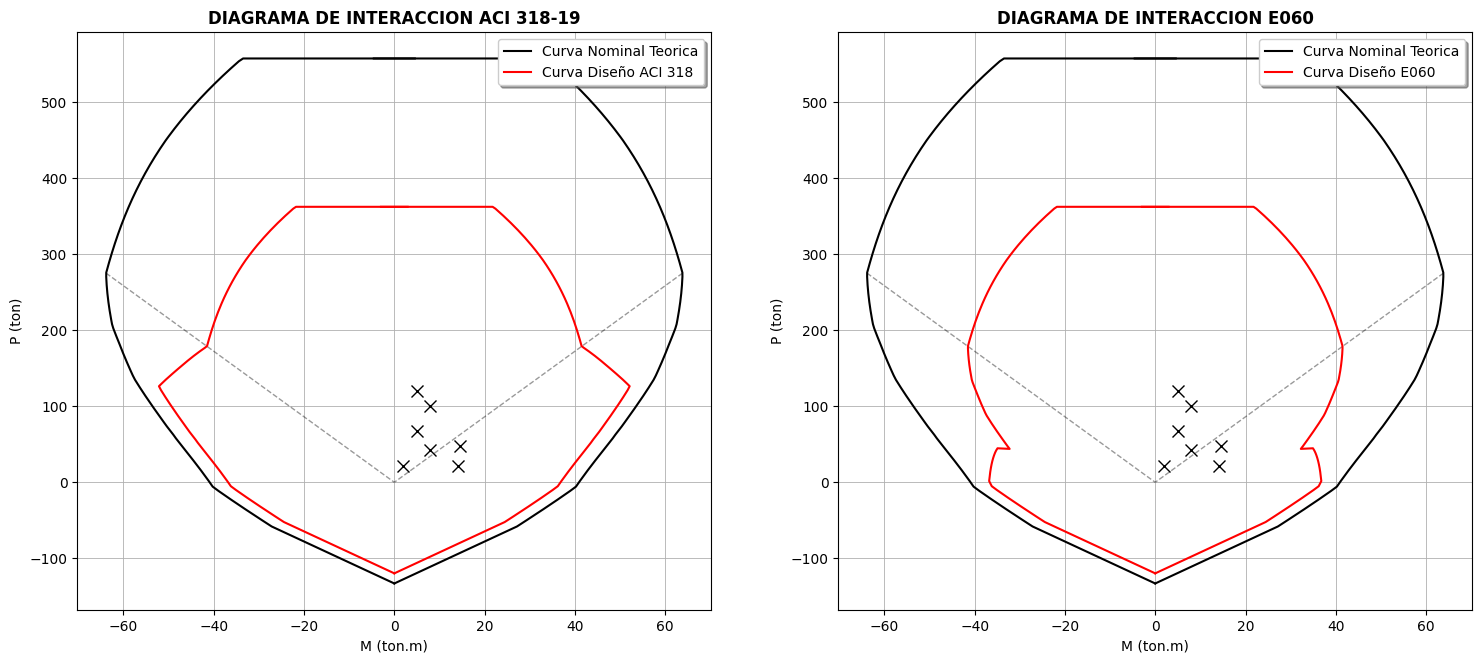

In [152]:
#DIAGRAMA DE INTERACCION 0° y 180°
#ACI
fig = plt.figure(figsize=(18,7.5))
ax1 = plt.subplot(1,2,1)
ax1.plot(np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='--',color="black", linewidth=1,alpha=0.4)
ax1.plot(-np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='--',color="black", linewidth=1,alpha=0.4)
C_N,=ax1.plot(np.array(momento_nom_r_ACI)/100000,np.array(carga_nom_r_ACI)/1000,linestyle='-',color="black")
ax1.plot(-np.array(momento_nom_r_ACI)/100000,np.array(carga_nom_r_ACI)/1000,linestyle='-',color="black")
C_D,=ax1.plot(np.array(momento_ult_r_ACI,dtype=object)/100000,np.array(carga_ult_r_ACI,dtype=object)/1000,linestyle='-',color="red")
ax1.plot(-np.array(momento_ult_r_ACI,dtype=object)/100000,np.array(carga_ult_r_ACI,dtype=object)/1000,linestyle='-',color="red")

ax1.plot(carga_momento,carga_compresion,"kx",ms=9)
ax1.set_ylabel("P (ton)")
ax1.set_xlabel("M (ton.m)")
ax1.set_title("DIAGRAMA DE INTERACCION ACI 318-19",fontweight="bold")
ax1.legend((C_N,C_D),("Curva Nominal Teorica","Curva Diseño ACI 318"), loc='upper right', shadow=True)
ax1.grid(linewidth=0.6)
plt.axis("on")
ax1.set_facecolor("white")

#E060
ax2 = plt.subplot(1,2,2)
ax2.plot(np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='--',color="black", linewidth=1,alpha=0.4)
C_N,=ax2.plot(np.array(momento_nom_r_E060)/100000,np.array(carga_nom_r_E060)/1000,linestyle='-',color="black")
C_D,=ax2.plot(np.array(momento_ult_r_E060)/100000,np.array(carga_ult_r_E060)/1000,linestyle='-',color="red")

ax2.plot(-np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='--',color="black", linewidth=1,alpha=0.4)
ax2.plot(-np.array(momento_nom_r_E060)/100000,np.array(carga_nom_r_E060)/1000, label="Curva Nominal",linestyle='-',color="black")
ax2.plot(-np.array(momento_ult_r_E060)/100000,np.array(carga_ult_r_E060)/1000,label="Curva Diseño",linestyle='-',color="red")

ax2.plot(carga_momento,carga_compresion,"kx",ms=9)
ax2.set_ylabel("P (ton)")
ax2.set_xlabel("M (ton.m)")
ax2.set_title("DIAGRAMA DE INTERACCION E060",fontweight="bold")
ax2.legend((C_N,C_D),("Curva Nominal Teorica","Curva Diseño E060"), loc='upper right', shadow=True)
ax2.grid(linewidth=0.6)
plt.axis("on")
ax2.set_facecolor("white")

## SECCION 

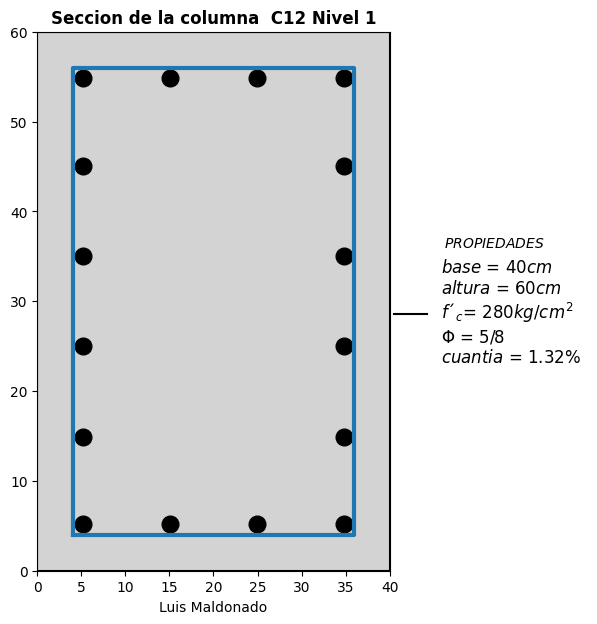

In [153]:
#SECCION DE LA COLUMNAS
fig_1=plt.figure(figsize=(10,7))
ax2=plt.subplot(1,2,1)
ax2.plot(rectangulo_x,rectangulo_y,"k-")
ax2.plot(vx,vy1,"ko",ms = 12)
ax2.plot(vx,vy2,"ko",ms = 12)
ax2.plot(vx1,vy,"ko",ms = 12)
ax2.plot(vx2,vy,"ko",ms = 12)
ax2.plot(estribo_x,estribo_y,linestyle='-',linewidth=3)
ax2.set_title("Seccion de la columna  " + str(etiqueta),fontweight="bold")
#plt.ylabel("Base (cm)")
plt.xlabel("Luis Maldonado",)
#plt.axis('off')
ax2.set_facecolor("lightgray")
ax2.set(xlim=(0,b), ylim=(0,h))
label = [ "$base$ = " +str(base)+ "$ cm$"+'\n$altura$ = '+str(altura)+ "$ cm$"+'\n$f´_{c} $= '+str(fc)+"$kg/cm^2$"+'\n$Φ$ = '+str(diametros)+'\n$cuantia$ = '+str(round(cuantia*100,2))+"%"]
#ax2.legend(label,loc='center left',bbox_to_anchor=(0.96, 0.5),frameon=False,title="   $ PROPIEDADES$",fontsize=12)
ax2.legend(label,loc='center left',bbox_to_anchor=(0.97, 0.5),frameon=False,title="   $ PROPIEDADES$",fontsize=12)
plt.show()

## **Creacion de seccion en Autocad**

In [154]:
from pyautocad import Autocad, APoint
acad=Autocad()     

doc=acad.ActiveDocument
ms=doc.ModelSpace

In [155]:
#SECCION
#variables y operaciones para definir la geometria de la seccion de la columna
b=base
h=altura
e=4       #cm  # recubrimiento
rx=1.2      #variable, hace referencias al diametro en el plot
ry=0.9
rectangulo_x=[0,b,b,0,0]
rectangulo_y=[0,0,h,h,0]
estribo_x=[e,b-e,b-e,e,e]
estribo_y=[e,e,h-e,h-e,e]
k_x=numero_aceros_x-1
k_y=numero_aceros_y-1
s_x=(b-2*e-2*rx)/k_x
s_y=(h-2*e-2*ry)/k_y
varillas_x=[]
varillas_y=[]
for i in range(numero_aceros_x):
    varillas_x.append((i)*s_x+e+rx)
for i in range(numero_aceros_y):
    varillas_y.append((i)*s_y+e+ry)
varillas_y.pop(0)
varillas_y.pop(-1)
vx=varillas_x
vy=varillas_y
#print(s_y)
vy1=[]
vy2=[]
vx1=[]
vx2=[]
for i in range(numero_aceros_x):
    vy1.append(e+1.2)
    vy2.append(h-e-1.2)
for i in range(numero_aceros_y-2):
    vx1.append(e+1.2)
    vx2.append(b-e-1.2)




# # #par  ok

# # #par  ok
# print(vy2)
# print(varillas_x)

# # #par  ok
# print(vx2)
# print(varillas_y)

# #par  ok
# print(vx1)
# print(varillas_y)


In [156]:
for i in range(4):
        p3=APoint(rectangulo_x[i], rectangulo_y[i])
        p4=APoint(rectangulo_x[i+1],rectangulo_y[i+1])
        line1= acad.model.AddLine(p3,p4)
        line1.layer='Long_rebar'

for i in range(4):
        p3=APoint(estribo_x[i], estribo_y[i])
        p4=APoint(estribo_x[i+1],estribo_y[i+1])
        line1= acad.model.AddLine(p3,p4)
        line1.layer='Stirrups_center'


for i in range(3):
        p3=APoint(vy1[i], varillas_x[i])
        p4=APoint(vy1[i+1],varillas_x[i+1])
        line1= acad.model.AddLine(p3,p4)
        line1.layer='Stirrups_center'

for i in range(4):
        p3=APoint(estribo_x[i], estribo_y[i])
        p4=APoint(estribo_x[i+1],estribo_y[i+1])
        line1= acad.model.AddLine(p3,p4)
        line1.layer='Stirrups_center'

print("Generacion de Plano Exitosa")

Generacion de Plano Exitosa


## COMPARACION DE RESULTADOS

### datos Section Designer SAP2000

In [157]:

# SAP_P_M="https://raw.githubusercontent.com/luis0098/Archivos/main/b40h50e5fc280acerosx5acerosy2diametro5-8.txt"
# A = np.genfromtxt(SAP_P_M,skip_header = 1,encoding='latin')
# P_SAP, M_SAP = A[:,0], A[:,1]


### PLOT

<img src="Imagenes\Section Designer C 40x50.jpg">

In [158]:
#@title
# recubrimiento=5    #cm
# fc=280             #kg/cm2    #Resistencia a la compresion del concreto 
# fy=4200            #kg/cm2    #Resistencia a la fluencia del acero
# Es=2.00*10**6      #kg/cm2    #Modulo de elasticidad del acero 
# base=40            #cm  
# altura=50          #cm 
# numero_aceros_x=5
# numero_aceros_y=2  
# diametros="5/8"     #pulg  "1/4"   "3/8"    "1/2"   "5/8"  "3/4"    "1"  



# fig = plt.figure(figsize=(11,7.5))
# ax4 = plt.subplot(1,2,1)
# #ACI
# ax4.plot(np.array(momento_nom_bal)/100000,np.array(carga_nom_bal)/1000,linestyle='-',color="black", linewidth=0.75)
# ax4.plot(np.array(momento_nom_ACI)/100000,np.array(carga_nom_ACI)/1000, label="Curva Nominal",linestyle='--',color="silver")
# C_N,=ax4.plot(np.array(momento_nom_r_ACI)/100000,np.array(carga_nom_r_ACI)/1000, label="Curva Nominal",linestyle='-',color="black")
# #C_D,=ax4.plot(np.array(momento_ult_r_ACI)/100000,np.array(carga_ult_r_ACI)/1000,label="Curva Diseño",linestyle='-',color="red")
# #SAP2000
# C_SAP,=ax4.plot(M_SAP/1000,P_SAP/1000,label="SAP2000",linestyle='-',color="mediumblue",linewidth=3)
# #E060
# C_D,=ax4.plot(np.array(momento_ult_r_E060)/100000,np.array(carga_ult_r_E060)/1000,label="Curva Diseño",linestyle='-',color="red")
# ax4.plot(carga_momento,carga_compresion,"kx")
# ax4.set_ylabel("P (ton)")
# ax4.set_xlabel("M (ton.m)")
# ax4.set_title("COMPARACION CON LOS RESULTADOS DEL SAP200 \nDIAGRAMA DE INTERACCION E060",fontweight="bold")

# ax4.legend((C_N,C_D,C_SAP),("Curva Nominal Teorica","Curva Diseño ACI 318","SAP2000"), loc='lower right', shadow=True)
# ax4.grid(linewidth=1)
# #ax4.set(xlim=(0), ylim=(0))
# ax4.set( xlim=(0))
# plt.axis("on")
# ax4.set_facecolor("white")
# label = ['$f´c$´= '+str(fc)+'\n$Φ$ = '+str(diametros) + '\n$base$ = '+str(base)+ "$ cm$"+'\n$altura$ = '+str(altura)+ "$ cm$"]
# ax4.legend(label,loc='center left',bbox_to_anchor=(0.96, 0.5),frameon=False,title="   $ PROPIEDADES$",fontsize=12)
# plt.show()